# Introduction

### Purpose
This notebook enables you to process electrical resistivity tomography (ERT) data from the Canadian Permafrost Electrical Resistivity Survey (CPERS) Nordicana D publication [will be submitted Spring 2023]. 

### Downloading data from Nordicana D
To begin, you will have to download the files from Nordicana D to your computer. Download the files containing metadata, electrode positions, and ERT measurements for the province of interest and save them in a common folder. For example:<br>
<pre>
|-Alaska sites<br>
|   |-Alaska_metadata.csv<br>
|   |-Alaska_electrode_positions.csv<br>
|   |-Alaska_ERT_measurements.csv<br>
</pre>

### Data policy
It is very important to follow the [CPERS data policy](https://data.permafrostnet.ca/cpers/data_policy.html). If you plan to use the data (e.g. in a publication, presentation, etc.), you must contact the PI indicated in the data publication to request permission and discuss with them the appropriate level of collaboration. Data must also be cited as indicated on the Nordicana D data publication.

### Data processing
ERT data processing involves filtering poor quality data points and running an inversion. Both steps require you to choose parameters (e.g. filtering thresholds, regularization, etc.). The values provided here were the ones used to process all datasets on the [CPERS website](https://data.permafrostnet.ca/cpers/) in a consistent, unified way. However, appropriate data processing parameters are somewhat site-specific and you may want to tweak them for a particular site or dataset. 

### Additional resources
* The Canadian Permafrost Electrical Resistivity Survey Database (CPERS) (Herring et al., manuscript in preparation) will be submitted to Arctic Science in Spring 2023. This paper will describe basic background information on ERT and the structure and contents of the CPERS database.
* [Automated time-lapse ERT for improved process analysis and monitoring of frozen ground](https://doi.org/10.1002/ppp.732) (Hilbich et al., 2011) and [Automatic filtering of ERT monitoring data in mountain permafrost](https://doi.org/10.3997/1873-0604.2013003) (Rosset et al., 2013). These papers describe the basis for the automated data filtering routine used here.
* [Rapid least-squares inversion of apparent resistivity pseudosections by a quasi-Newton method](https://doi.org/10.1111/j.1365-2478.1996.tb00142.x) (Loke and Barker, 1996) is one of the foundational pieces of literature describing ERT inversion.
* [Inversion for applied geophysics: a tutorial](https://doi.org/10.1190/1.9781560801719.ch5) (Oldenburg and Li, 2005) provides a great in-depth background on the fundamentals of inversion.
* Best practices for using electrical resistivity tomography to investigate permafrost (Herring et al., manuscript under review in Permafrost and Periglacial Processes) reviews the literature suggests best practices for acquiring, processing, and interpreting ERT data collected in permafrost environments
    

In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import math


## load the files that you downloaded from Nordicana D

In [2]:
# load all data for region

folder_name = 'Alaska sites' # specify folder here
region_name = 'Alaska' # specify region here
survey_name = 'US_DHP_L01_2010-07-22_01' # specify survey name here (find this in the metadata file)

filepath = '/Users/teddiherringnew/Desktop/postdoc/nordicana d/v2/' # path to the data directory goes here
topo =  pd.read_csv(filepath + folder_name + '/' + region_name + '_electrode_positions.csv') 
measurements =  pd.read_csv(filepath + folder_name + '/' + region_name + '_ERT_measurements.csv')

# isolate specific survey

topo = topo[topo['DB_SurveyName']==survey_name]
measurements = measurements[measurements['DB_SurveyName']==survey_name]

# correct for zero indexing:
measurements['a'] = measurements['a']-1
measurements['b'] = measurements['b']-1
measurements['m'] = measurements['m']-1
measurements['n'] = measurements['n']-1

## put into pygimli data container

In [3]:
data_raw = pg.DataContainerERT()

if 'y' not in topo.columns:
    topo['y'] = np.zeros(len(topo['x']))

# add electrode locations
for i in range(0,len(topo)):
    data_raw.createSensor([topo['x'].values[i], topo['z'].values[i]]) # 2D, no topography

# add data electrode indices
for i in range(0,len(measurements)):
    data_raw.createFourPointData(i, *map(int, [measurements['a'].values[i],measurements['b'].values[i],measurements['m'].values[i],measurements['n'].values[i]])) 

# add data
if 'r' in measurements.columns:
    data_raw['r'] = measurements['r'].values
    
if 'rhoa' in measurements.columns:
    data_raw['rhoa'] = measurements['rhoa'].values
    
if 'u' in measurements.columns:
    data_raw['u'] = measurements['u'].values
    
if 'i' in measurements.columns:
    data_raw['i'] = measurements['i'].values
    
if 'err' in measurements.columns:
    data_raw['err'] = measurements['err'].values

data_raw

Data: Sensors: 81 data: 445, nonzero entries: ['a', 'b', 'err', 'i', 'm', 'n', 'u', 'valid']

## check the data
* calculate geometric factor and apparent resistivity if not already in data file
* look for reciprocal or repeated measurements. if present, calculate new apparent resistivities and error values

In [4]:
# calculate geometric factor and apparent resistivity if not already in data file

if data_raw.haveData('k')==False:
    data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation
    
if data_raw.haveData('rhoa')==False:
    if data_raw.haveData('r')==False:
        data_raw['r'] = data_raw['u']/data_raw['i']
    data_raw['rhoa'] = data_raw['r']*data_raw['k'] 


# put data into pandas dataframe

df = pd.DataFrame(np.array(data_raw.dataMap(),dtype='object').T)
header = df.iloc[0]
df = df[1:] 
df.columns = header
df = df.apply(pd.Series.explode).reset_index(drop=True)

df_raw = pd.DataFrame(df)
df_raw['start_index'] = df_raw.index

# look for reciprocal or repeated measurements

src = np.stack([df_raw['a'],df_raw['b']]).T
rec = np.stack([df_raw['m'],df_raw['n']]).T

src_f = src[0]
rec_f = rec[0]
ind_f = [0]
ind_r = []
reps = []
recips = []

for i in range(1,len(src)): 

    if len(rec_f)==2:
        a = np.where(np.all(rec_f==src[i],axis=0))[0] # reciprocals
        b = np.where(np.all(src_f==rec[i],axis=0))[0]
        
        c = np.where(np.all(src_f==src[i],axis=0))[0] # repeated
        d = np.where(np.all(rec_f==rec[i],axis=0))[0]
    else:
        a = np.where(np.all(rec_f==src[i],axis=1))[0] # reciprocals
        b = np.where(np.all(src_f==rec[i],axis=1))[0]
        
        c = np.where(np.all(src_f==src[i],axis=1))[0] # repeated
        d = np.where(np.all(rec_f==rec[i],axis=1))[0]   
        
    ind_recip = np.intersect1d(a,b)
    ind_rep = np.intersect1d(c,d)
        
    if len(ind_recip)>0:
        ind_r.append(i)
        recips.append(ind_recip)
            
    elif len(ind_rep)>0:
        ind_r.append(i)
        reps.append(ind_rep)
        
    else:
        src_f = np.vstack((src_f,[src[i]]))
        rec_f = np.vstack((rec_f,[rec[i]]))
        ind_f.append(i)
        
if len(recips)>0:
    recips = np.array([np.squeeze(recips)])
if len(reps)>0:
    reps = np.array([np.squeeze(reps)])

print('%.0f reciprocal measurements detected'%len(recips))     
print('%.0f repeated measurements detected'%len(reps))

# treat repeated and reciprocal measurements the same
r_all = np.hstack([reps,recips]).astype(int)

# if present, calculate new apparent resistivities and error vals

df_f = df_raw.loc[ind_f]
df_f = df_f.reset_index(drop=True)

df_r = df_raw.loc[ind_r]
df_r = df_r.reset_index(drop=True)

df_checked = df_f.copy()
df_checked['rep/recip'] = 0

if len(ind_r)>0: #TODO this only handles recips now

    for i in range(len(ind_r)): # for all reciprocal measurements

        r_mean = (df_f.iloc[r_all[i]]['r'] + df_r.iloc[i]['r'])/2 
        r_err = (np.abs(df_f.iloc[r_all[i]]['r'] - df_r.iloc[i]['r'])/abs(r_mean))*100    
        df_checked.at[r_all[i],'r'] = r_mean
        df_checked.at[r_all[i],'rhoa'] = r_mean*df_r.iloc[i]['k']
        df_checked.at[r_all[i],'err'] = r_err
        df_checked.at[r_all[i],'rep/recip'] = 1

03/05/23 - 00:29:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/ert-app/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (8.3s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1216531786208943767


0 reciprocal measurements detected
0 repeated measurements detected


## function to put dataframe into pygimli data container

In [5]:
def make_pg_container(data_raw, dataframe):

    data_container = pg.DataContainerERT()

    for i in range(0,len(data_raw.sensors())):
        data_container.createSensor(np.array(data_raw.sensors()[i])) 

    # add filtered quadripoles and data 

    cols = dataframe.columns
    for i in range(len(cols)):
        if max(dataframe[cols[i]]) > 0:
            data_container[cols[i]] = np.array(dataframe[cols[i]])
            
    return data_container


## set some font sizes for plots

In [6]:
fs=22 # title
fs1=60 # subplots
fs2=16 # ticks
fs3=20 # labels

## plot the observed data 

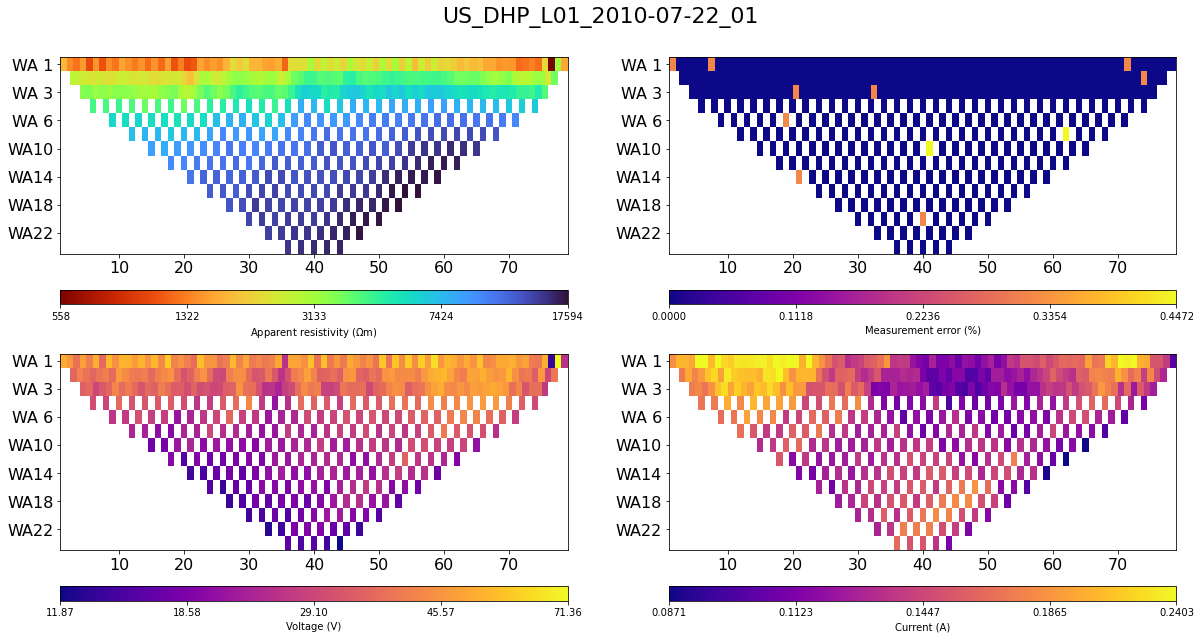

In [7]:
# put everything back into the pygimli data container to plot
data_checked = make_pg_container(data_raw, df_checked)
        
mgr = ert.ERTManager(data_checked)

fig, ax = plt.subplots(2,2,figsize=[20,10])

mgr.showData(
    data_checked, 
    vals=data_checked['rhoa'],
    ax=ax[0,0],
    label=r'Apparent resistivity ($\Omega$m)',
    cMap='turbo_r',
)

if data_checked.haveData('err'):
    mgr.showData(
        data_checked, 
        vals=data_checked['err'],
        ax=ax[0,1],
        label='Measurement error (%)',
        cMap='plasma'
    )
else:
    ax[0,1].text(0.25,0.5,'no measurement error data available',fontsize=16)
    
if data_checked.haveData('u'):
    mgr.showData(
        data_checked, 
        vals=data_checked['u'],
        ax=ax[1,0],
        label='Voltage (V)',
        cMap='plasma'
    )
else:
    ax[1,0].text(0.3,0.5,'no voltage data available',fontsize=16)
    
if data_checked.haveData('i'):
    mgr.showData(
        data_checked, 
        vals=data_checked['i'],
        ax=ax[1,1],
        label='Current (A)',
        cMap='plasma'
    )
else:
    ax[1,1].text(0.3,0.5,'no current data available',fontsize=16)
    
for a in ax.flat:
    a.tick_params(axis='both', which='major', labelsize=fs2)

plt.suptitle('%s'%(survey_name),fontsize=fs, y=0.95);

plt.savefig('observed_data.png',format='png',bbox_inches='tight')


## set some thresholds

In [8]:
th_err = 5 # threshold for measurement error (%)
th_std = 9 # removes data > 9*std(rhoa)
th_mmf = 0.15 # threshold for moving median filter  TODO: make this higher for shallower data?
th_elec_filt = 25 # threshold for determining bad electrode (%) - if more than x% data using an electrode are filtered, remove the rest
th_bad_dataset = 20 # threshold for determining dataset quality (%) - if more than x% of all data points are removed, discard entire dataset
z_weight = 1 # directional smoothness constraint

## step 1: technical filter & step 2: magnitude filter

In [9]:
df_filt = df_checked.copy()

i1 = np.where(df_filt['i'] <= 0)[0]
i2 = np.where(df_filt['u'] <= 0)[0]
i3 = np.where(df_filt['rhoa'] <= 0)[0]
i4 = np.where(df_filt['err'] > th_err)[0]
i5 = np.where(df_filt['rhoa'] > th_std*np.std(df_filt['rhoa']))[0]

if len(i1) == len(df_filt):
    i1 = []
if len(i2) == len(df_filt):
    i2 = []

I_tf = (np.unique(np.hstack([i1,i2,i3,i4,i5])))

df_filt = df_filt.drop(I_tf)
n_tf = len(I_tf)

df_tf = df_filt.copy()

## sort data for moving median filter

In [10]:
# to apply a moving median filter we will need to sort our data by depth level and array midpoint. 

# find midpoint of array

mp = np.mean([df_filt['a'],df_filt['b'],df_filt['m'],df_filt['n']],axis=0)

# sort by depth level and midpoint so we can apply moving median filter
# note: this works for 2D lines with topography and even electrode spacing

# to find unique depth levels, check to find unique relative positions of electrodes

ab = df_filt['a'] - df_filt['b']
am = df_filt['a'] - df_filt['m']
an = df_filt['a'] - df_filt['n']

# pos is just a placeholder variable describing relative electrode positions...

pos = (np.array([ab,am,an]).T).astype(dtype=float)
pos_uniq = np.flipud(np.unique(pos, axis=0))

# ...and we'll add this info to dataframe for convenience

pos_i = []
for i in range(len(pos)):
    pos_i.append(np.where((pos[i]==pos_uniq).all(axis=1))[0][0])

df_filt['pos'] = pos_i

# sort by depth level

sort_index = np.argsort(pos)
i_all = np.linspace(0,len(pos),len(pos)+1).astype('int')
sort_index = np.array([])

# sort by midpoint

for i in range(len(pos_uniq)):
    j = np.where((pos==pos_uniq[i]).all(axis=1))
    si = np.argsort(mp[j])
    sort_index = np.append(sort_index,i_all[j][si]) 

sort_index = sort_index.astype('int')

# make a dataframe with sorted values

df_sort = pd.DataFrame(columns = df_filt.columns,index=range(len(df_filt)))
for i in range(len(df_filt)):
    df_sort.iloc[i] = df_filt.iloc[sort_index[i]]
df_sort = df_sort.reset_index(drop=True)

## step 3: moving median filter

In [11]:

df_filt = df_sort.copy()

n_mmf = 0 # keeping track of how many data are removed

ikeep = np.ones(df_filt.shape[0],dtype=bool)

for j in range(len(pos_uniq)): # loop through each unique depth level
    I = (np.where(df_filt['pos']==j)[0])
    
    # moving median of data points
    
    mm = [] 
    r = np.log(np.array(df_filt['rhoa'],dtype=float)[I])
   
    for i in range(len(I)): # loop through depth level from left to right
        if i==0:
            mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
        elif i==1:
            mm.append(np.median(r[i-1:4])) 
        elif i==len(r)-2:
            mm.append(np.median(r[i-2:])) 
        elif i==len(r)-1:
            mm.append(np.median(r[i-2:])) 
        else:
            mm.append(np.median(r[i-2:i+3])) 
    
    ithrow = np.where(abs(r-mm)/mm > th_mmf)[0]
    n_mmf = n_mmf + len(ithrow)
    
    # get rid of outlier data 
    
    for i in range(len(ithrow)):
        ikeep[I[ithrow[i]]] = 0
        
I_mmf = (df_filt[ikeep==False])['start_index']
df_filt = df_filt[ikeep]
df_filt = df_filt.reset_index(drop=True)

df_mmf = df_filt.copy()

## step 4: bad electrode filter

In [12]:
# find the indices of all the points we removed
I_all = np.hstack([I_tf,I_mmf])

# how many times was each electrode used in the full dataset?
[elec_all,count_all] = np.unique(np.hstack([df_raw['a'],df_raw['b'],df_raw['m'],df_raw['n']]), return_counts=True)

# how many times was each electrode used in the data that got removed?
df_removed = df_raw[df_raw['start_index'].isin(I_all)]
[elec_removed,count_removed] = np.unique(np.hstack([df_removed['a'],df_removed['b'],df_removed['m'],df_removed['n']]), return_counts=True)

# loop through and, for each electrode, calculate what percentage of data points were removed
perc_filt = []
for i in range(len(elec_all)):
    if elec_all[i] in elec_removed:
        I = np.where(elec_removed == elec_all[i])
        perc_filt.append(count_removed[I]/count_all[i]*100)
        
    else:
        perc_filt.append([0])
        
perc_filt = np.hstack(perc_filt)

# identify which electrodes are bad based on a threshold 
# (here, if more than 25% of data with that electrode have been filtered)
e_bad = elec_all[perc_filt > th_elec_filt]

if len(e_bad)==len(data_raw.sensors()): # i.e. if all electrodes are "bad"
    print('ABORT: too many bad electrodes. Data should not be inverted.')
    
I_ef = []
for i in range(len(df_filt['a'])):
    if (df_filt['a'].iloc[i] in e_bad) or (df_filt['b'].iloc[i] in e_bad) or (df_filt['m'].iloc[i] in e_bad) or (df_filt['n'].iloc[i] in e_bad):
        I_ef.append(True)
    else:
        I_ef.append(False)
        
df_elec_filt = df_filt.drop(index = np.where(I_ef)[0])
n_ef = len(e_bad)
df_filt = df_elec_filt.copy()


if len(df_filt)==0: # i.e. if all data points are "bad"
    print('ABORT: too many bad electrodes. Data should not be inverted.')
    

## plot filtered data (simple plot)

data points removed by technical filter = 0
data points removed by moving median filter = 0
number of bad electrodes = 0
data points removed by bad electrode filter = 0
0 data points removed in total (0.0% of the data)


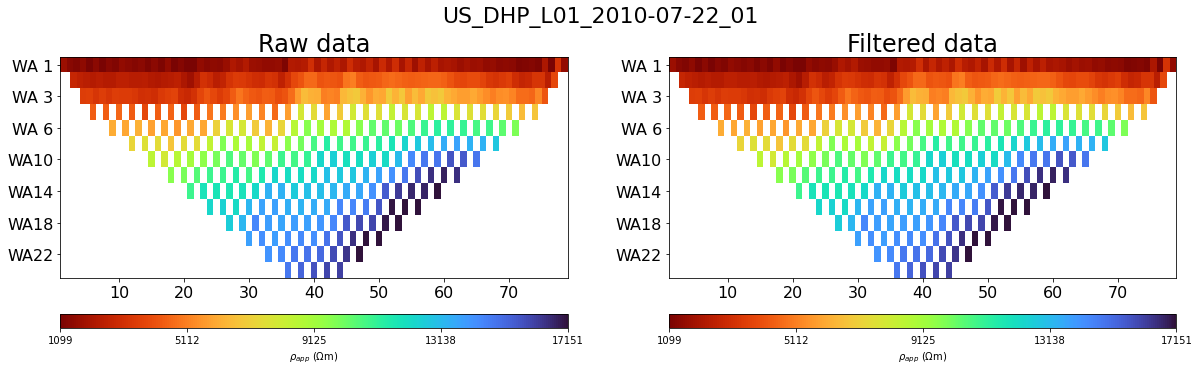

In [13]:
# put everything back into the pygimli data container
data_filt = make_pg_container(data_raw, df_filt)

# trim color limits to make things easier to see. or you can set your own
cmin = np.sort(data_filt['rhoa'])[int(len(data_filt['rhoa'])/100+1)]
cmax = np.sort(data_filt['rhoa'])[-int(len(data_filt['rhoa'])/100+1)]

fig, ax = plt.subplots(1,2,figsize=[20,5])

mgr = ert.ERTManager(data_checked)
mgr.showData(
    data_checked, 
    vals=data_checked['rhoa'],
    ax=ax[0],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=cmin,
    cMax=cmax,
    logScale=False # don't use logscale here b/c there are sometimes negative resistances in raw data which will break plot
);

ax[0].set_title('Raw data',fontsize=24);

mgr = ert.ERTManager(data_filt)
mgr.showData(
    data_filt, 
    vals=data_filt['rhoa'],
    ax=ax[1],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=cmin,
    cMax=cmax,
    logScale=False
);
ax[1].set_title('Filtered data',fontsize=24);

for a in ax.flat:
    a.tick_params(axis='both', which='major', labelsize=fs2)

plt.suptitle('%s'%(survey_name),fontsize=fs, y=1.02)

print('data points removed by technical filter = %.0f'%n_tf)
print('data points removed by moving median filter = %.0f'%n_mmf)
print('number of bad electrodes = %.0f'%n_ef)
print('data points removed by bad electrode filter = %.0f'%len(np.where(I_ef)[0]))
print('%.0f data points removed in total (%.1f%% of the data)'%(data_checked.size()-data_filt.size(), float((data_checked.size()-data_filt.size())/data_checked.size()*100)))


if (data_checked.size()-data_filt.size())/data_checked.size()*100>th_bad_dataset: # i.e. if >30% data are removed
    print('ABORT: too many data points filtered. Data should not be inverted.')

plt.savefig('filtering_summary_plot.png',format='png',bbox_inches='tight')


## create error model

In [14]:
# TODO - set a minimum amount of repeated/reciprocal data that we would need to make an error model

# if there are reciprocal/repeated data, use those to make an error model

if len (r_all)>(len(df_filt['a'])/3): # only create custom error model if we have enough repeated/reciprocal measurements. TODO make sure 1/3 of dataset is a good number

    
    I = np.where(df_filt['rep/recip']==1)
    x = abs(df_filt['r'].iloc[I])
    y = abs(df_filt['err'].iloc[I])*abs(df_filt['r'].iloc[I])/100 # absolute error
    
    nbins = 20
    ndata = len(I[0])
    npoints = math.ceil(ndata/nbins)

    df_filt = df_filt.sort_values(by=['r'],key=abs)
    xbin = []
    ybin = []
    for i in range(nbins):
        xbin.append(np.mean(x[i*npoints:(i+1)*npoints]))
        ybin.append(np.std(y[i*npoints:(i+1)*npoints]))

    p = np.polyfit(xbin,ybin, 1)
        
    if p[1]<0: # if absolute error is negative, just assign some small value
        p[1]=1e-3
    p[0] = p[0] + 0.02 # increase relative error by 2% to account for other sources of error
    
    print('error model: err = %.4f*|R|+%.4f'%(p[0],p[1]))

    # automated (from error model)
    data_filt['err'] = ert.estimateError(
    data_filt, 
    absoluteError=p[1], 
    relativeError=p[0] # % noise
    ) 
    
# if no repeated/reciprocal data, just assume a 4% error model

else:
    
    data_filt['err'] = ert.estimateError(
    data_filt, 
    absoluteError=0.001, 
    relativeError=0.04 # % noise
    )
    
    

## invert the data

In [15]:
mgr = ert.ERTManager(data_filt)

# set whether lambda is being optimized by L-curve
mgr.inv.inv.setOptimizeLambda(True)

# use blocky model constraint
mgr.inv.inv.setBlockyModel(True)

# run inversion
mod = mgr.invert(
    data_filt,    
)

# getting lambda, chi2, rms error

lam = mgr.inv.inv.getLambda()
chi2 = mgr.inv.inv.getChi2()
rms = np.sqrt(np.mean(((data_filt['rhoa']-mgr.inv.response)/data_filt['rhoa'])**2))*100
mae = np.mean(((data_filt['rhoa']-mgr.inv.response)/data_filt['rhoa']))*100

03/05/23 - 00:29:39 - pyGIMLi - INFO - Found 2 regions.
03/05/23 - 00:29:39 - pyGIMLi - INFO - Region with smallest marker (1) set to background
03/05/23 - 00:29:39 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
03/05/23 - 00:29:39 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
03/05/23 - 00:29:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/05/23 - 00:29:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
03/05/23 - 00:29:39 - pyGIMLi - INFO - Use median(data values)=5860.864941770323
03/05/23 - 00:29:39 - pyGIMLi - INFO - Created startmodel from forward operator: 1347 [5860.864941770323,...,5860.864941770323]


## plot the results (model)

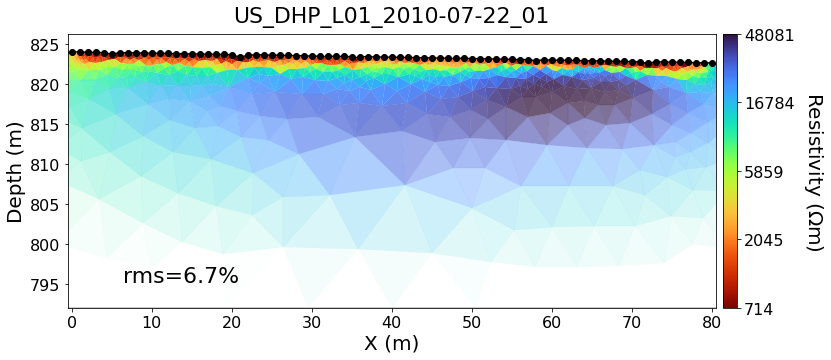

In [16]:

fig, ax = plt.subplots(1,1,figsize=[12,10])

cmin=np.round(np.sort(mgr.paraModel())[int(len(mgr.paraModel())/100)]) # this part trims the color scale to make things easier to see
cmax=np.round(np.sort(mgr.paraModel())[-int(len(mgr.paraModel())/100)])

ax, cBar = mgr.showResult(
   mod,
    ax=ax,
    cMap='turbo_r',
    coverage=mgr.coverage(),
    cMin=cmin,
    cMax=cmax,
    orientation='vertical'
);

ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.plot(topo['x'],topo['z'],'ko')
ax.tick_params(axis='both', which='major', labelsize=fs2)
ax.set_xlabel('X (m)',fontsize=fs3)
ax.set_ylabel('Depth (m)',fontsize=fs3)
cBar.set_label(r'Resistivity ($\Omega$m)',rotation=270,fontsize=fs3,labelpad=30)
cBar.ax.tick_params(labelsize=fs2)
cBar.ax.set_yticklabels(np.round(cBar.get_ticks()).astype('int').astype('str').tolist())  # vertically oriented colorbar

xmin = min(topo['x'])
xmax = max(topo['x'])
ymin = mgr.paraDomain.yMin()
ymax = mgr.paraDomain.yMax()
e_pad = min(np.diff(topo['x']))/2
ax.set_xlim([xmin-e_pad,xmax+e_pad])
ax.set_ylim([ymin,ymax+abs(ymax-ymin)*0.07])
ax.text(xmin+(xmax-xmin)*0.08,ymin+(ymax-ymin)*0.1,'rms=%.1f%%'%(rms),fontsize=fs);
ax.set_title('%s'%(survey_name),fontsize=fs, y=1.02);

plt.savefig('results_model.png',format='png',bbox_inches='tight',dpi=500)


## plot the results (data fit)

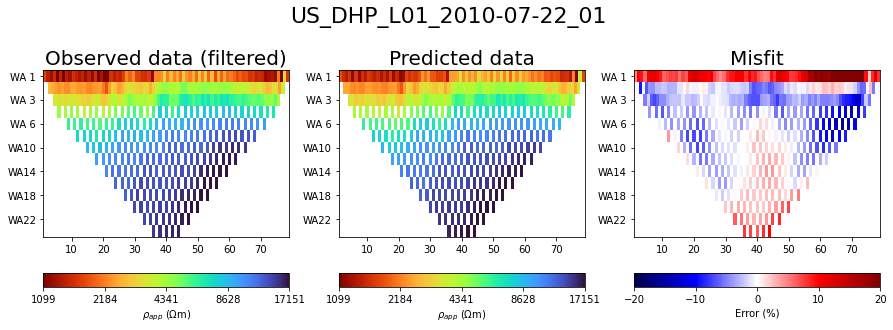

In [17]:

fig, ax = plt.subplots(1,3,figsize=[15,4])

cmin = np.sort(data_filt['rhoa'])[int(len(data_filt['rhoa'])/100+1)]
cmax = np.sort(data_filt['rhoa'])[-int(len(data_filt['rhoa'])/100+1)]

mgr.showData(
    vals=data_filt['rhoa'],
    ax=ax[0],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=cmin, 
    cMax=cmax,
    logScale=True
);

mgr.showData(
    vals=mgr.inv.response,
    ax=ax[1],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=cmin, 
    cMax=cmax,
    logScale=True
);

mgr.showData(
    vals=((mgr.inv.response-data_filt['rhoa'])/data_filt['rhoa'])*100,
    ax=ax[2],
    label='Error (%)',
    cMap='seismic',
    cMin=-20,
    cMax=20
);

ax[0].set_title('Observed data (filtered)',fontsize=20)
ax[1].set_title('Predicted data',fontsize=20)
ax[2].set_title('Misfit',fontsize=20);

plt.suptitle('%s'%(survey_name),fontsize=fs, y=1.1);

plt.savefig('results_data.png',format='png',bbox_inches='tight')
